In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio # for loading MATLAB files
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, welch

import os

In [8]:
raw_data_path = 'data/pers_data/raw/' # path to raw data
processed_data_path = 'data/pers_data/cleaned/' # path to processed data

# Create directories if they do not exist
os.makedirs(raw_data_path, exist_ok=True)
os.makedirs(processed_data_path, exist_ok=True)

In [17]:
for root, d_names, f_names in os.walk(raw_data_path):
    print('File names:', f_names)

File names: ['WS_R_4_250328161002.csv', 'WS_R_4_250328161356.csv', 'WS_R_4_250328161516.csv', 'WS_R_4_250328161630.csv', 'WS_R_4_250328161835.csv', 'WS_R_4_250328161941.csv', 'WS_R_4_250328162058.csv', 'WS_R_4_250328162840.csv', 'WS_R_4_250328163057.csv', 'WS_R_4_250328163152.csv', 'WS_R_4_250328164449.csv', 'WS_R_4_250328164936.csv', 'WS_R_4_250328165059.csv', 'WS_R_4_250328165201.csv']


In [18]:
for file in f_names:
    raw_data = pd.read_csv(raw_data_path + file)
    print(raw_data.head())

   Timestamp  Channel1  Channel2 Action1 Action2
0      0.000     506.0     482.0    Rest     NaN
1      0.161     506.0     480.0    Rest     NaN
2      0.161     506.0     479.0    Rest     NaN
3      0.161     506.0     477.0    Rest     NaN
4      0.162     506.0     475.0    Rest     NaN
   Timestamp  Channel1  Channel2 Action1 Action2
0      0.000     510.0     517.0    Rest     NaN
1      0.137     509.0     513.0    Rest     NaN
2      0.139     509.0     508.0    Rest     NaN
3      0.139     508.0     503.0    Rest     NaN
4      0.139     509.0     498.0    Rest     NaN
   Timestamp  Channel1  Channel2 Action1 Action2
0      0.001     511.0     470.0    Rest     NaN
1      0.130     511.0     473.0    Rest     NaN
2      0.130     512.0     474.0    Rest     NaN
3      0.131     512.0     475.0    Rest     NaN
4      0.131     512.0     477.0    Rest     NaN
   Timestamp  Channel1  Channel2 Action1 Action2
0      0.000     509.0     521.0    Rest     NaN
1      0.131     509

In [27]:
def hampel_filter(series, window_size=3, n_sigmas=3):
    """Applies Hampel filter to a 1D pandas Series."""
    L = 1.4826  # scale factor for Gaussian distribution
    rolling_median = series.rolling(window=2 * window_size + 1, center=True).median()
    diff = np.abs(series - rolling_median)
    mad = L * diff.rolling(window=2 * window_size + 1, center=True).median()
    
    # Identify outliers
    outlier_idx = diff > n_sigmas * mad
    filtered = series.copy()
    filtered[outlier_idx] = rolling_median[outlier_idx]
    return filtered

In [33]:
def clean_data(raw_data):
    cleaned_data = raw_data.copy()
    
    # Remove the first row
    cleaned_data = cleaned_data.drop(index=0)

    # Number of channels
    num_channels = 2

    # Compute the average sampling frequency and jitter
    sampling_freq = 1 / np.mean(np.diff(cleaned_data["Timestamp"]))
    jitter = np.mean(np.diff(cleaned_data["Timestamp"]))
    print(f"Sampling Frequency: {sampling_freq} Hz")
    print(f"Jitter: {jitter} seconds")

    # # Resample the data to a fixed sampling frequency (e.g., 1000 Hz)
    # target_rate = 2000  # Hz
    # start_time = cleaned_data['Timestamp'].iloc[0]
    # end_time = cleaned_data['Timestamp'].iloc[-1]
    # uniform_time = np.arange(start_time, end_time, 1 / target_rate)
    # # Interpolate both channels to the new time grid
    # resampled_data = pd.DataFrame({
    #     'Timestamp': uniform_time,
    #     })
    # for i in range(num_channels):
    #     resampled_data["Channel{}".format(i+1)] = np.interp(uniform_time, cleaned_data["Timestamp"], cleaned_data["Channel{}".format(i+1)])
    # # Still misses the Action columns...


    for i in range(num_channels): # nb of channels
        channel = cleaned_data["Channel{}".format(i+1)]

        # Normalize the channel
        channel = (channel - np.mean(channel))/np.std(channel)

        # Filter 50Hz noise using a Hampel filter
        channel = hampel_filter(channel)

        cleaned_data["Channel{}".format(i+1)] = channel
    
    return cleaned_data

In [34]:
for file in f_names:
    raw_data = pd.read_csv(raw_data_path + file)
    cleaned_data = clean_data(raw_data)
    print(cleaned_data.head())
    break
    # cleaned_data.to_csv(processed_data_path + file + "cleaned", index=False)

Sampling Frequency: 1461.9821283509343 Hz
Jitter: 0.0006840028893704506 seconds
   Timestamp  Channel1  Channel2 Action1 Action2
1      0.161 -0.565049 -0.787373    Rest     NaN
2      0.161 -0.565049 -0.815220    Rest     NaN
3      0.161 -0.565049 -0.870914    Rest     NaN
4      0.162 -0.565049 -0.926608    Rest     NaN
5      0.162 -0.443307 -1.010148    Rest     NaN


Text(0.5, 0.98, 'Rectified EMG signal for restimulus 1')

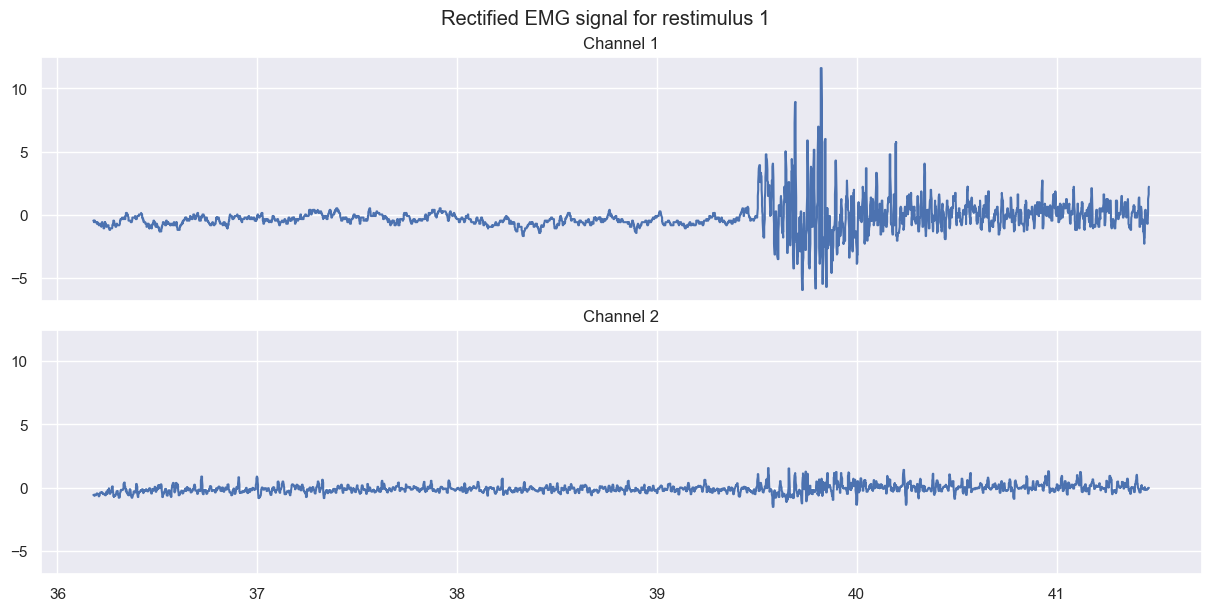

In [35]:
start_id = cleaned_data[(cleaned_data["Action1"] == "Rest") & (cleaned_data["Action2"] == "Fist")].index[0]
end_id = cleaned_data[(cleaned_data["Action1"] == "Fist") & (cleaned_data["Action2"] == "Rest")].index[-1]
window_df = cleaned_data.loc[start_id:end_id]

# plt.figure(figsize=(12, 4))
# plt.plot(window_df['Timestamp'], window_df['Channel1'], label='Channel1')
# plt.plot(window_df['Timestamp'], window_df['Channel2'], label='Channel2')
# plt.title("First 'Fist' Action Window")
# plt.xlabel("Time (s)")
# plt.ylabel("Signal")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")